In [88]:
import os.path
import zipfile
import subprocess
import io

import nltk
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer

from nltk.tag import StanfordNERTagger
from nltk.tag import StanfordPOSTagger
from nltk.parse import stanford
from nltk.tokenize import word_tokenize
from nltk.tree import Tree
from nltk.draw.tree import TreeView
from nltk.tokenize import sent_tokenize

import IPython.display

%matplotlib inline

To using the [Stanford NLP group](http://nlp.stanford.edu/) programs with nltk requires a bit of setup. We are basing these instructions on those provided by nltk, [here](https://github.com/nltk/nltk/wiki/Installing-Third-Party-Software#stanford-tagger-ner-tokenizer-and-parser), but with a couple of changes for the notebooks.

1. Install [Java 1.8+](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html)
    + Make sure your `JAVAPATH` is setup if you're on windows
2. Download the following zip files from the Stanford NLP group, where DATE is the release date of the files, this will be the value of `stanfordVersion`
    + `stanford-postagger-full-DATE.zip`
    + `stanford-ner-DATE.zip`
    + `stanford-parser-full-DATE.zip`
3. Unzip the files and place the resulting directories in the same location, this will become `stanfordDir`
4. Lookup the version number used by the parser `stanford-parser-VERSION-models.jar` and set to to be `parserVersion`

In [60]:
#This is the date at the end of each of the zip files, e.g.
#the date in stanford-ner-2016-10-31.zip
stanfordVersion = '2016-10-31'

#This is the version numbers of the parser models, these
#are files in `stanford-parser-full-2016-10-31.zip`, e.g.
#stanford-parser-3.7.0-models.jar
parserVersion = '3.7.0'

#This is where the zip files were unzipped.Make sure to
#unzip into directories named after the zip files
#Don't just put all the files in `stanford-NLP`
stanfordDir = 'shared/stanford-NLP'

#Parser's model
modelName = 'englishPCFG.ser.gz'

Setting up NER tagger

In [3]:
nerClassifierPath = os.path.join(stanfordDir,'stanford-ner-{}'.format(stanfordVersion), 'classifiers/english.all.3class.distsim.crf.ser.gz')

nerJarPath = os.path.join(stanfordDir,'stanford-ner-{}'.format(stanfordVersion), 'stanford-ner.jar')

nerTagger = StanfordNERTagger(nerClassifierPath, nerJarPath)

setting up POS Tagger

In [4]:
postClassifierPath = os.path.join(stanfordDir, 'stanford-postagger-full-{}'.format(stanfordVersion), 'models/english-bidirectional-distsim.tagger')

postJarPath = os.path.join(stanfordDir,'stanford-postagger-full-{}'.format(stanfordVersion), 'stanford-postagger.jar')

postTagger = StanfordPOSTagger(postClassifierPath, postJarPath)

Setting up Parser

In [5]:
parserJarPath = os.path.join(stanfordDir, 'stanford-parser-full-{}'.format(stanfordVersion), 'stanford-parser.jar')

parserModelsPath = os.path.join(stanfordDir, 'stanford-parser-full-{}'.format(stanfordVersion), 'stanford-parser-{}-models.jar'.format(parserVersion))

modelPath = os.path.join(stanfordDir, 'stanford-parser-full-{}'.format(stanfordVersion), modelName)

if not os.path.isfile(modelPath):
    with zipfile.ZipFile(parserModelsPath) as zf:
        with open(modelPath, 'wb') as f:
            f.write(zf.read('edu/stanford/nlp/models/lexparser/{}'.format(modelName)))

parser = stanford.StanfordParser(parserJarPath, parserModelsPath, modelPath)

depParser = stanford.StanfordDependencyParser(parserJarPath, parserModelsPath)

POS tagging

In [6]:
text = 'While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal.'

tokenized_text = word_tokenize(text)

print(postTagger.tag(tokenized_text))

[('While', 'IN'), ('in', 'IN'), ('France', 'NNP'), (',', ','), ('Christine', 'NNP'), ('Lagarde', 'NNP'), ('discussed', 'VBD'), ('short-term', 'JJ'), ('stimulus', 'NN'), ('efforts', 'NNS'), ('in', 'IN'), ('a', 'DT'), ('recent', 'JJ'), ('interview', 'NN'), ('with', 'IN'), ('the', 'DT'), ('Wall', 'NNP'), ('Street', 'NNP'), ('Journal', 'NNP'), ('.', '.')]


In [61]:
def openIE(targetSting, tempFileName = 'IE_TEMPFILE'):
    coreDir = '{}/stanford-corenlp-full-{}'.format(stanfordDir, stanfordVersion)
    cp = '{0}/stanford-corenlp-{1}.jar:{0}/stanford-corenlp-{1}-models.jar:CoreNLP-to-HTML.xsl:slf4j-api.jar:slf4j-simple.jar'.format(coreDir, parserVersion)
    with open(tempFileName, 'w') as f:
        f.write(targetSting)
    sp = subprocess.run(['java', '-mx2g', '-cp', cp, 'edu.stanford.nlp.naturalli.OpenIE', '-threads', '1', f.name], stdout = subprocess.PIPE)
    retSting = sp.stdout.decode('utf-8')
    os.remove(tempFileName)
    with io.StringIO(retSting) as f:
        df = pandas.read_csv(f, delimiter = '\t', names =['certainty', 'subject', 'verb', 'object'] )
    return df

In [86]:
df = openIE('The quick brown fox jumped over the lazy dog. While in France, Christine Lagarde discussed short-term stimulus efforts in a recent interview with the Wall Street Journal. I saw the elephant in my pajamas.')

In [87]:
df

certainty                      subject                           verb  \
0         1.0              quick brown fox                    jumped over   
1         1.0                          fox                    jumped over   
2         1.0                    quick fox                    jumped over   
3         1.0              quick brown fox                    jumped over   
4         1.0                    brown fox                    jumped over   
5         1.0                    brown fox                    jumped over   
6         1.0                    quick fox                    jumped over   
7         1.0                          fox                    jumped over   
8         1.0            Christine Lagarde                      discussed   
9         1.0            Christine Lagarde                      discussed   
10        1.0            Christine Lagarde                      discussed   
11        1.0            Christine Lagarde  discussed stimulus efforts in   
12        1.0            Christine Lagarde                      discussed   
13        1.0            Christine Lagarde                      discussed   
14        1.0            Christine Lagarde                      discussed   
15        1.0  short-term stimulus efforts                          is in   
16        1.0            Christine Lagarde                      discussed   
17        1.0            Christine Lagarde                      discussed   
18        1.0            Christine Lagarde                      discussed   
19        1.0            Christine Lagarde                      discussed   
20        1.0             recent interview                        is with   
21        1.0                     elephant                          is in   
22        1.0                            I                            saw   
23        1.0                            I                            saw   

                                               object  
0                                            lazy dog  
1                                                 dog  
2                                                 dog  
3                                                 dog  
4                                            lazy dog  
5                                                 dog  
6                                            lazy dog  
7                                            lazy dog  
8   short-term stimulus efforts in interview with ...  
9                       stimulus efforts in interview  
10               stimulus efforts in recent interview  
11                                             France  
12  short-term stimulus efforts in recent intervie...  
13    short-term stimulus efforts in recent interview  
14  stimulus efforts in recent interview with Wall...  
15          recent interview with Wall Street Journal  
16  stimulus efforts in interview with Wall Street...  
17                        short-term stimulus efforts  
18                                   stimulus efforts  
19           short-term stimulus efforts in interview  
20                                Wall Street Journal  
21                                         my pajamas  
22                             elephant in my pajamas  
23                                           elephant

Named-Entity Recognition

In [7]:
classified_text = nerTagger.tag(tokenized_text)
print(classified_text)

[('While', 'O'), ('in', 'O'), ('France', 'LOCATION'), (',', 'O'), ('Christine', 'PERSON'), ('Lagarde', 'PERSON'), ('discussed', 'O'), ('short-term', 'O'), ('stimulus', 'O'), ('efforts', 'O'), ('in', 'O'), ('a', 'O'), ('recent', 'O'), ('interview', 'O'), ('with', 'O'), ('the', 'O'), ('Wall', 'ORGANIZATION'), ('Street', 'ORGANIZATION'), ('Journal', 'ORGANIZATION'), ('.', 'O')]


Non-Dependency Parsing

In [8]:
pars = parser.raw_parse(text) #Parse a single sentence
tree = list(pars)[0]
print(tree)

(ROOT
  (S
    (SBAR (IN While) (FRAG (PP (IN in) (NP (NNP France)))))
    (, ,)
    (NP (NNP Christine) (NNP Lagarde))
    (VP
      (VBD discussed)
      (NP (JJ short-term) (NN stimulus) (NNS efforts))
      (PP (IN in) (NP (DT a) (JJ recent) (NN interview)))
      (PP
        (IN with)
        (NP (DT the) (NNP Wall) (NNP Street) (NNP Journal))))
    (. .)))


In [10]:
tree.pretty_print()

                                                                                 ROOT                                                               
                                                                                  |                                                                  
                                                                                  S                                                                 
        __________________________________________________________________________|_______________________________________________________________   
      SBAR              |             |                                                              |                                            | 
   ____|____            |             |                                                              |                                            |  
  |        FRAG         |             |                                                              VP

In [ ]:
TreeView(tree)._cframe.print_to_file('output.ps')
os.system('convert output.ps output1.png')

In [ ]:
#import Ipython.core.display
IPython.display.display(tree)

<img src="output1.png">

Dependency Parsing

In [ ]:
result = depParser.raw_parse(text)

In [ ]:
G = list(result)[0]

In [ ]:
G.tree()

In [ ]:
f = open('output.dot', 'w')
f.write(G.to_dot())
f.close()

In [ ]:
os.system("dot -Tpng output.dot > output2.png")

<img src="output2.png">

Lets work with the Clinton-Obama-Sanders dataset again,

In [58]:
df = pandas.read_csv('data/ObamaClintonSandersReleases.csv', index_col = 0)

In [97]:
def split_sentences(text):
    sents = [item.strip() for item in text.split('    ') if item != '']
    return sents

In [98]:
df['sentences'] = df['text'].apply(lambda x: split_sentences(x))

In [99]:
df['sentences'][0]

['Obama Calls on IRS to Protect Taxpayers',
 'Privacy   U S  Senator Barack Obama',
 'Barack Obama',
 'Obama Calls on IRS to Protect Taxpayers',
 'Privacy Monday  April  9  2007  FOR IMMEDIATE RELEASE   Contact  Ben LaBolt  Following reports of lax security procedures  asks for investigation  solution WASHINGTON  DC',
 'U S  Senator Barack Obama  D IL  today sent a letter calling on Internal Revenue Service Commissioner Mark Everson to fully account for the loss of computers containing sensitive taxpayer information  to audit vulnerabilities taxpayers face when they turn over personal information to the IRS  and to find a solution that protects taxpayers',
 'privacy   The Washington Post reported last week that an Inspector General report found that',
 'thousands of taxpayers could be at risk of identity theft or other financial fraud because the Internal Revenue Service has failed to adequately protect information on its 52 000 laptop computers and other storage systems',
 'and that 5

In [74]:
pars = parser.raw_parse(df['sentences'][0][0])

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.
Parsing file: c:\cygwin64\tmp\tmp16aj3t
Parsing [sent. 1 len. 699]: Obama Calls on IRS to Protect Taxpayers Privacy U S Senator Barack Obama Barack Obama Obama Calls on IRS to Protect Taxpayers Privacy Monday April 9 2007 FOR IMMEDIATE RELEASE Contact Ben LaBolt Following reports of lax security procedures asks for investigation solution WASHINGTON DC U S Senator Barack Obama D IL today sent a letter calling on Internal Revenue Service Commissioner Mark Everson to fully account for the loss of computers containing sensitive taxpayer information to audit vulnerabilities taxpayers face when they turn over personal information to the IRS and to find a solution that protects taxpayers privacy The Washington Post reported last week that an Inspector General report found that thousands

OSError: Java command failed : ['C:\\Program Files\\Java\\jdk1.8.0_121\\bin\\java.exe', u'-mx1000m', '-cp', 'C:\\users\\shilin\\documents\\stanford\\stanford-parser-full-2016-10-31\\stanford-parser-3.7.0-models.jar;C:\\users\\shilin\\documents\\stanford\\stanford-parser-full-2016-10-31\\ejml-0.23.jar;C:\\users\\shilin\\documents\\stanford\\stanford-parser-full-2016-10-31\\slf4j-api-1.7.12-sources.jar;C:\\users\\shilin\\documents\\stanford\\stanford-parser-full-2016-10-31\\slf4j-api.jar;C:\\users\\shilin\\documents\\stanford\\stanford-parser-full-2016-10-31\\stanford-parser-3.7.0-javadoc.jar;C:\\users\\shilin\\documents\\stanford\\stanford-parser-full-2016-10-31\\stanford-parser-3.7.0-models.jar;C:\\users\\shilin\\documents\\stanford\\stanford-parser-full-2016-10-31\\stanford-parser-3.7.0-sources.jar;C:\\users\\shilin\\documents\\stanford\\stanford-parser-full-2016-10-31\\stanford-parser.jar', u'edu.stanford.nlp.parser.lexparser.LexicalizedParser', u'-model', 'C:\\users\\shilin\\documents\\stanford\\stanford-parser-full-2016-10-31\\englishPCFG.ser.gz', u'-sentences', u'newline', u'-outputFormat', u'penn', u'-encoding', u'utf8', 'c:\\cygwin64\\tmp\\tmp16aj3t']

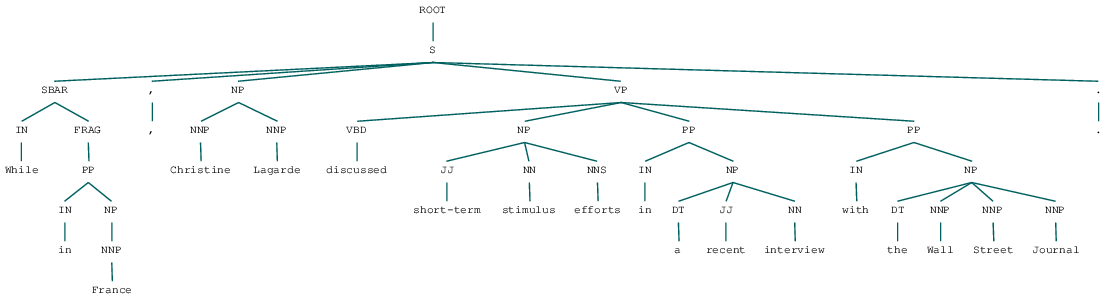

In [67]:
list(pars)[0]